## Overview
Learning EDA, time spend ~8hrs

Credit: [Jenny Raikakou, End-to-End Recommendation System Guide](https://www.kaggle.com/code/eraikako/end-to-end-recommendation-system-guide)

Dataset: [OTTO – Multi-Objective Recommender System](https://www.kaggle.com/competitions/otto-recommender-system/data) and [Otto Full Optimized Memory Footprint](https://www.kaggle.com/datasets/radek1/otto-full-optimized-memory-footprint)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import glob
import dask.dataframe as dd
from pathlib import Path

data_path = Path('otto-recommender-system/')

# from pathlib import
# Path file_path = Path("example. txt") if file_path. is_file(): print(f"{file_path} exists.") else: print(f"{file_path} does not exist.")

In [ ]:
for dirname, _, filenames in os.walk('otto-recommender-system/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

otto-recommender-system/train.jsonl
otto-recommender-system/test.jsonl
otto-recommender-system/final_output.parquet
otto-recommender-system/sample_submission.csv
otto-recommender-system/parquet-files/output_chunk_302.parquet
otto-recommender-system/parquet-files/output_chunk_312.parquet
otto-recommender-system/parquet-files/output_chunk_557.parquet
otto-recommender-system/parquet-files/output_chunk_547.parquet
otto-recommender-system/parquet-files/output_chunk_1080.parquet
otto-recommender-system/parquet-files/output_chunk_1919.parquet
otto-recommender-system/parquet-files/output_chunk_749.parquet
otto-recommender-system/parquet-files/output_chunk_1861.parquet
otto-recommender-system/parquet-files/output_chunk_631.parquet
otto-recommender-system/parquet-files/output_chunk_1909.parquet
otto-recommender-system/parquet-files/output_chunk_759.parquet
otto-recommender-system/parquet-files/output_chunk_1090.parquet
otto-recommender-system/parquet-files/output_chunk_1871.parquet
otto-recommen

## Loading Train JSON Files & Converting to Parquet

In [ ]:
# Read and display a few lines to understand the structure
file_path  = "otto-recommender-system/train.jsonl"
with open(file_path, "r", encoding="utf-8") as f:
    for _ in range(5):  # Read first 5 lines
        print(json.loads(f.readline()))

{'session': 0, 'events': [{'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'}, {'aid': 1563459, 'ts': 1659304904511, 'type': 'clicks'}, {'aid': 1309446, 'ts': 1659367439426, 'type': 'clicks'}, {'aid': 16246, 'ts': 1659367719997, 'type': 'clicks'}, {'aid': 1781822, 'ts': 1659367871344, 'type': 'clicks'}, {'aid': 1152674, 'ts': 1659367885796, 'type': 'clicks'}, {'aid': 1649869, 'ts': 1659369893840, 'type': 'carts'}, {'aid': 461689, 'ts': 1659369898050, 'type': 'carts'}, {'aid': 305831, 'ts': 1659370027105, 'type': 'orders'}, {'aid': 461689, 'ts': 1659370027105, 'type': 'orders'}, {'aid': 362233, 'ts': 1659370064916, 'type': 'clicks'}, {'aid': 1649869, 'ts': 1659370067686, 'type': 'clicks'}, {'aid': 1649869, 'ts': 1659371003682, 'type': 'clicks'}, {'aid': 984597, 'ts': 1659371033243, 'type': 'clicks'}, {'aid': 1649869, 'ts': 1659371042297, 'type': 'clicks'}, {'aid': 803544, 'ts': 1659371044075, 'type': 'clicks'}, {'aid': 1110941, 'ts': 1659371104329, 'type': 'clicks'}, {'aid': 1190046

In [ ]:
# Funciton to process the file in chunks
def process_jsonl_in_chunks(file_path, chunk_size=100_000):
    """Reads large JSONL file efficiently in chunks and converts it to a DataFrame."""
    data = []
    batch = 0

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            record = json.loads(line) # Load each JSON object

            # Extract session id and expand the events
            session_id = record['session']
            for event in record['events']:
                event['session'] = session_id # Add session ID to each event
                data.append(event)

            # Process in chunks
            if len(data) >= chunk_size:
                df = pd.DataFrame(data)
                df.to_parquet(f'otto-recommender-system/parquet-files/output_chunk_{batch}.parquet', index=False) # Save to parquet
                print(f'Processed {batch * chunk_size} rows...')
                data = [] # Reset list
                batch += 1

    # Process any remaining data
    if data:
        df = pd.DataFrame(data)
        df.to_parquet(f'otto-recommender-system/parquet-files/output_chunk_{batch}.parquet', index=False) # Save to parquet
        print(f'Final batch processed {batch * chunk_size} rows.')

    print('Processing complete. Data saved to parquet files.')

In [ ]:
# Run processing function
# process_jsonl_in_chunks(file_path)

In [ ]:
# files = glob.glob("otto-recommender-system/parquet-files/output_chunk_*.parquet")
# df = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)
# df.to_parquet("otto-recommender-system/final_output.parquet", index=False)

In [ ]:
# Load Parquet file
file_path = "otto-recommender-system/final_output.parquet"
df = dd.read_parquet(file_path)
df.head(5)

,aid,ts,type,session
0,666629,1659365211261,clicks,713672
1,735855,1661618559985,clicks,713672
2,1206220,1659365211346,clicks,713673
3,39846,1659365229740,clicks,713673
4,486780,1659365292507,clicks,713673


## Load the Test Dataset

In [ ]:
tes_file_path = "otto-recommender-system/test.jsonl"
data = []

# Step 1: Read the JSONL file directly
with open(tes_file_path, 'r', encoding='utf-8') as f:
    data = [json.loads(line) for line in f]

# Step 2: Expand the nested 'events' column
flattened_data = []
for record in data:
    session_id = record['session']
    for event in record['events']:
        event['session'] = session_id  # Add session ID to each event
        flattened_data.append(event)

# Step 3: Convert to DataFrame
df_test = pd.DataFrame(flattened_data)
print(f'df_test.shape: {df_test.shape}, \ndf_test.head():')
df_test.head()

df_test.shape: (6928123, 4), 
df_test.head():


,aid,ts,type,session
0,59625,1661724000278,clicks,12899779
1,1142000,1661724000378,clicks,12899780
2,582732,1661724058352,clicks,12899780
3,973453,1661724109199,clicks,12899780
4,736515,1661724136868,clicks,12899780


## Exploratory Data Analysis (EDA)

### 1. Data Overview & Basic Statistics:
```
Check the number of unique sessions and total events. ✅
Identify the distribution of event types (clicks, cart additions, orders). ✅
Examine the time range covered in the dataset (earliest & latest timestamps). ✅
Identify missing values or anomalies
```

In [ ]:
# Convert Unix timestamp to datetime (milliseconds assumed)
df['datetime'] = dd.to_datetime(df['ts'], unit='ms')

In [ ]:
df.head()

,aid,ts,type,session,datetime
0,666629,1659365211261,clicks,713672,2022-08-01 14:46:51.261
1,735855,1661618559985,clicks,713672,2022-08-27 16:42:39.985
2,1206220,1659365211346,clicks,713673,2022-08-01 14:46:51.346
3,39846,1659365229740,clicks,713673,2022-08-01 14:47:09.740
4,486780,1659365292507,clicks,713673,2022-08-01 14:48:12.507


In [ ]:
nb_unique_sessions = df['session'].nunique().compute()
print(f'Number of unique sessions in the training set: {nb_unique_sessions}')
print(f'Number of total events in the training set: {df.shape[0].compute()}')
print(f'Earliest timestamp in the training set: {df["datetime"].min().compute()}')
print(f'Latest timestamp in the training set: {df["datetime"].max().compute()}')
print(f'Number of unique article ids (aids, product codes) in the training set: {df["aid"].nunique().compute()}')

# Check for missing values (NaNs) in each column
missing_values = df.isnull().sum().compute()
print('Check for missing values')
print('-------------------------------------')
missing_values

Number of unique sessions in the training set: 12899779
Number of total events in the training set: 216716096
Earliest timestamp in the training set: 2022-07-31 22:00:00.025000
Latest timestamp in the training set: 2022-08-28 21:59:59.984000
Number of unique article ids (aids, product codes) in the training set: 1855603
Check for missing values
-------------------------------------


aid         0
ts          0
type        0
session     0
datetime    0
dtype: int64

```
Key Features:

12.9M real-world anonymized user sessions
216.7M events, consiting of clicks, carts and orders
1.86M unique articles in the catalogue
```

In [ ]:
# Count occurrences of each event type
event_counts = df['type'].value_counts().compute().reset_index()
event_counts.columns = ['Event Type', 'Count']
# Calculate percentage
event_counts['Percentage'] = (event_counts['Count'] / event_counts['Count'].sum()) * 100
event_counts

,Event Type,Count,Percentage
0,orders,5098951,2.352825
1,clicks,194720954,89.850711
2,carts,16896191,7.796463


In [ ]:
# Test data analysis
# Convert Unix timestamp to datetime (milliseconds assumed)
df_test['datetime'] = pd.to_datetime(df_test['ts'], unit='ms')
df_test.head()

,aid,ts,type,session,datetime
0,59625,1661724000278,clicks,12899779,2022-08-28 22:00:00.278
1,1142000,1661724000378,clicks,12899780,2022-08-28 22:00:00.378
2,582732,1661724058352,clicks,12899780,2022-08-28 22:00:58.352
3,973453,1661724109199,clicks,12899780,2022-08-28 22:01:49.199
4,736515,1661724136868,clicks,12899780,2022-08-28 22:02:16.868


In [ ]:
nb_unique_sessions_test = df_test['session'].nunique()
print(f'Number of unique sessions in the test set: {nb_unique_sessions_test}')
print(f'Number of total events in the test set: {df_test.shape[0]}')
print(f'Earliest timestamp in the test set: {df_test["datetime"].min()}')
print(f'Latest timestamp in the test set: {df_test["datetime"].max()}')
print(f'Number of unique article ids (aids, product codes) in the test set: {df_test["aid"].nunique()}')
# Check for missing values (NaNs) in each column
missing_values_test = df_test.isnull().sum()
print('Check for missing values')
print('-------------------------------------')
missing_values_test

Number of unique sessions in the test set: 1671803
Number of total events in the test set: 6928123
Earliest timestamp in the test set: 2022-08-28 22:00:00.278000
Latest timestamp in the test set: 2022-09-04 21:59:51.563000
Number of unique article ids (aids, product codes) in the test set: 783486
Check for missing values
-------------------------------------


aid         0
ts          0
type        0
session     0
datetime    0
dtype: int64

In [ ]:
# Count occurrences of each event type
event_counts_test = df_test['type'].value_counts().reset_index()
event_counts_test.columns = ['Event Type', 'Count']

# Calculate percentage
event_counts_test['Percentage'] = (event_counts_test['Count'] / event_counts_test['Count'].sum()) * 100
event_counts_test

,Event Type,Count,Percentage
0,clicks,6292632,90.827371
1,carts,570011,8.227495
2,orders,65480,0.945133


In [ ]:
# df['session'].unique().compute()
mask = df['session'].isin(df_test['session'].unique()).compute()
mask.value_counts()

session
False    216716096
Name: count, dtype: int64

```
Total overlapping session IDs: 0
Total overlapping article IDs (AIDs): 783486
Session ID Overlap Percentage: 0.00%
AID Overlap Percentage: 100.00%
```

### 2. Session-Level Analysis:

```
Analyze the distribution of session lengths (number of events per session). ✅
Identify sessions with only one event vs. sessions with multiple interactions. ✅
Study how session lengths correlate with conversions (do longer sessions result in more orders?).
```

In [ ]:
# Step 1: Group by session and count the number of events per session
session_lengths = df.groupby('session').size().compute().reset_index(name='num_events')
session_lengths
# Step 2: Display the distribution of session lengths
# Basic descriptive statistics
session_length_stats = session_lengths['num_events'].describe()
session_length_stats
print(f'session_lengths_stats: \n{session_length_stats}\n')
print(f'session_lengths: \n{session_lengths}')

session_lengths_stats: 
count    1.289978e+07
mean     1.679999e+01
std      3.357738e+01
min      2.000000e+00
25%      3.000000e+00
50%      6.000000e+00
75%      1.500000e+01
max      5.000000e+02
Name: num_events, dtype: float64

session_lengths: 
           session  num_events
0             2700          36
1             2701          22
2             2702          76
3             2703          20
4             2704          13
...            ...         ...
12899774  12796794           2
12899775  12796795          39
12899776  12796796           7
12899777  12796797           2
12899778  12796798           8

[12899779 rows x 2 columns]


In [ ]:
# find session_lengths with num_events equal to 1
df_simp = df[['ts', 'session', 'type', 'datetime']].copy()
df_simplified = df_simp.compute()
df_simplified

,ts,session,type,datetime
0,1659365211261,713672,clicks,2022-08-01 14:46:51.261
1,1661618559985,713672,clicks,2022-08-27 16:42:39.985
2,1659365211346,713673,clicks,2022-08-01 14:46:51.346
3,1659365229740,713673,clicks,2022-08-01 14:47:09.740
4,1659365292507,713673,clicks,2022-08-01 14:48:12.507
...,...,...,...,...
12243771,1661624523655,1894983,clicks,2022-08-27 18:22:03.655
12243772,1661624543492,1894983,clicks,2022-08-27 18:22:23.492
12243773,1661624557895,1894983,clicks,2022-08-27 18:22:37.895
12243774,1661624777781,1894983,clicks,2022-08-27 18:26:17.781


In [ ]:
# compute each session length/interval
grouped = df_simplified.groupby('session')
df_simplified['interval'] = grouped['datetime'].diff()
df_simplified

,ts,session,type,datetime,interval
0,1659365211261,713672,clicks,2022-08-01 14:46:51.261,NaT
1,1661618559985,713672,clicks,2022-08-27 16:42:39.985,26 days 01:55:48.724000
2,1659365211346,713673,clicks,2022-08-01 14:46:51.346,NaT
3,1659365229740,713673,clicks,2022-08-01 14:47:09.740,0 days 00:00:18.394000
4,1659365292507,713673,clicks,2022-08-01 14:48:12.507,0 days 00:01:02.767000
...,...,...,...,...,...
12243771,1661624523655,1894983,clicks,2022-08-27 18:22:03.655,0 days 00:00:13.965000
12243772,1661624543492,1894983,clicks,2022-08-27 18:22:23.492,0 days 00:00:19.837000
12243773,1661624557895,1894983,clicks,2022-08-27 18:22:37.895,0 days 00:00:14.403000
12243774,1661624777781,1894983,clicks,2022-08-27 18:26:17.781,0 days 00:03:39.886000


In [ ]:
# Find unique values in Types per session
# unique_types = grouped['type'].unique()
# df_unique_types = unique_types.to_frame()
# df_unique_types.rename(columns={'type': 'type_list_unique'}, inplace=True)
# merged_df = pd.merge(df_simplified, df_unique_types, on='session', how='left')
# merged_df

# Alternative: shortened version for quick testing
# df_2 = df_simplified[:10000].copy()
# grouped_2 = df_2.groupby('session')
# output = grouped_2['type'].unique()
# df_3 = output.to_frame()
# df_3.rename(columns={'type': 'type_list'}, inplace=True)
# df_3
# df_merged = pd.merge(df_2, df_3, on='session', how='left')
# df_merged

# Option 2: Find all values in Type (non-unique) per session
# df_2 = df_simplified[:10000].copy()
# grouped_2 = df_2.groupby('session')
# type_values = grouped_2['type'].agg(list)
# df_type_values = type_values.to_frame()
# df_type_values.rename(columns={'type': 'type_list_non_unique'}, inplace=True)
# df_merged_2 = pd.merge(df_2, df_type_values, on='session', how='left')
# df_merged_2

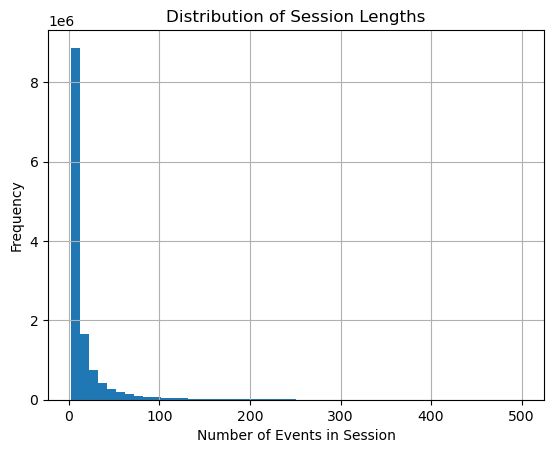

In [ ]:
session_lengths['num_events'].hist(bins=50)
plt.title('Distribution of Session Lengths')
plt.xlabel('Number of Events in Session')
plt.ylabel('Frequency')
plt.show()

### 3. Event Type Distribution:

```
Compare the proportions of clicks, cart additions, and orders. ✅
Examine how many sessions contain only clicks vs. those that proceed to cart and order. ✅
Identify patterns in event sequences (e.g., common paths from click → cart → order).
```

In [ ]:
# Define event types to keep
event_types_to_keep = ['carts', 'orders']

# Step 1: Identify sessions that contain "cart" or "order"
session_filter = df[df['type'].isin(event_types_to_keep)]['session'].unique().compute()

# Step 2: Filter the original DataFrame to keep only these sessions
filtered_df = df[df['session'].isin(session_filter)]

# Define event type mappings
filtered_df['is_click'] = (filtered_df['type'] == 'clicks').astype('int8')
filtered_df['is_cart'] = (filtered_df['type'] == 'carts').astype('int8')
filtered_df['is_order'] = (filtered_df['type'] == 'orders').astype('int8')
filtered_df.head(10)

,aid,ts,type,session,datetime,is_click,is_cart,is_order
19,1852929,1659365211435,clicks,713674,2022-08-01 14:46:51.435,1,0,0
20,139359,1659365235561,clicks,713674,2022-08-01 14:47:15.561,1,0,0
21,1179811,1659365873685,clicks,713674,2022-08-01 14:57:53.685,1,0,0
22,582150,1659373978513,clicks,713674,2022-08-01 17:12:58.513,1,0,0
23,139752,1659373992303,clicks,713674,2022-08-01 17:13:12.303,1,0,0
24,387594,1659374018308,clicks,713674,2022-08-01 17:13:38.308,1,0,0
25,1762221,1659374035152,clicks,713674,2022-08-01 17:13:55.152,1,0,0
26,189208,1659435033621,clicks,713674,2022-08-02 10:10:33.621,1,0,0
27,189208,1659435278348,clicks,713674,2022-08-02 10:14:38.348,1,0,0
28,189208,1659435532462,carts,713674,2022-08-02 10:18:52.462,0,1,0


In [ ]:
num_rows = filtered_df.shape[0].compute()  # Compute row count
num_columns = len(filtered_df.columns)  # Column count

print(f"Shape of DataFrame: ({num_rows}, {num_columns})")
print(f"The number of unique sessions that have at least one cart or order: {filtered_df['session'].nunique().compute()}")

Shape of DataFrame: (143170192, 8)
The number of unique sessions that have at least one cart or order: 3846669


In [ ]:
# Step 1: Group by session and sum up the click, cart, and order counts
session_event_counts = (
    filtered_df.groupby('session')
    .agg(
        num_events = ('is_click', 'size'),
        total_clicks = ('is_click', 'sum'),
        total_carts = ('is_cart', 'sum'),
        total_orders = ('is_order', 'sum')
    )
    .compute()
    .reset_index()
)

# Rename columns for clarity
session_event_counts.columns = ["session_id", "num_events", "num_clicks", "num_carts", "num_orders"]
session_event_counts.head()

,session_id,num_events,num_clicks,num_carts,num_orders
0,713674,117,85,32,0
1,713675,3,2,1,0
2,713676,20,17,2,1
3,713678,137,128,8,1
4,713680,3,2,1,0


In [ ]:
session_event_counts["num_events"].describe()

count    3.846669e+06
mean     3.721926e+01
std      5.180998e+01
min      3.000000e+00
25%      9.000000e+00
50%      1.900000e+01
75%      4.300000e+01
max      5.000000e+02
Name: num_events, dtype: float64

In [ ]:
total_sessions = session_event_counts.shape[0]
clicks_carts = session_event_counts[(session_event_counts['num_carts'] > 0) & (session_event_counts['num_orders'] == 0) ].shape[0]
clicks_carts_orders = session_event_counts[(session_event_counts['num_carts'] > 0) & (session_event_counts['num_orders'] > 0) ].shape[0]
clicks_ordrers = session_event_counts[(session_event_counts['num_orders'] > 0) & (session_event_counts['num_carts'] == 0) ].shape[0]

print(f"Number of unique sessions that contain at least one extra event except for clicks: {total_sessions} - ~{round((total_sessions / nb_unique_sessions) * 100)}% of the total number of unique sessions in the dataset.")

print("-------------------------------------------------------------------------------------------------------------------------------------")
print("The percentages below are calculated based on the number of unique sessions that contain at least one extra event except for clicks!")
print(f"Number of unique sessions that contain clicks and carts events: {clicks_carts} - ~{round((clicks_carts / total_sessions) * 100)}%")
print(f"Number of unique sessions that contain clicks, carts and orders events: {clicks_carts_orders} - ~{round((clicks_carts_orders / total_sessions) * 100)}%")
print(f"Number of unique sessions that contain clicks and orders events: {clicks_ordrers} - ~{round((clicks_ordrers / total_sessions) * 100)}%")

Number of unique sessions that contain at least one extra event except for clicks: 3846669 - ~30% of the total number of unique sessions in the dataset.
-------------------------------------------------------------------------------------------------------------------------------------
The percentages below are calculated based on the number of unique sessions that contain at least one extra event except for clicks!
Number of unique sessions that contain clicks and carts events: 2220331 - ~58%
Number of unique sessions that contain clicks, carts and orders events: 1590375 - ~41%
Number of unique sessions that contain clicks and orders events: 35963 - ~1%


In [ ]:
only_clicks = df[~df['session'].isin(session_filter)]['session'].nunique().compute()
print(f"Number of unique sessions that contain ONLY clicks events: {only_clicks} ~{round((only_clicks / nb_unique_sessions) * 100)}% of the total number of unique sessions in the dataset.")

Number of unique sessions that contain ONLY clicks events: 9053110 ~70% of the total number of unique sessions in the dataset.


In [ ]:
only_clicks_df = df[~df['session'].isin(session_filter)]
only_clicks_stats = (
    only_clicks_df.groupby("session")
    .agg(
        num_events=("session", "size"),         # Count total events per session
    )
    .compute()
    .reset_index()
)
only_clicks_stats["num_events"].describe()

count    9.053110e+06
mean     8.123828e+00
std      1.461181e+01
min      2.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      4.970000e+02
Name: num_events, dtype: float64

### 4. Time-Based Patterns:

```
Explore the distribution of timestamps (e.g., peak activity hours). ✅
Analyze session duration (time difference between first and last event). ✅
Study time gaps between events within a session.
```

In [ ]:
# Extract time-based features
df['hour'] = df['datetime'].dt.hour

# Extract the weekday name
df["weekday"] = df["datetime"].dt.strftime("%A") # Full weekday name (e.g., "Monday")

# Extract day of the week as a number (0 = Monday, 6 = Sunday)
df["weekday_number"] = df["datetime"].dt.weekday

# Extract the month name
df["month"] = df["datetime"].dt.month # Full month name (e.g., "August")

In [ ]:
df.compute().head()

,aid,ts,type,session,datetime,hour,weekday,weekday_number,month
0,666629,1659365211261,clicks,713672,2022-08-01 14:46:51.261,14,Monday,0,8
1,735855,1661618559985,clicks,713672,2022-08-27 16:42:39.985,16,Saturday,5,8
2,1206220,1659365211346,clicks,713673,2022-08-01 14:46:51.346,14,Monday,0,8
3,39846,1659365229740,clicks,713673,2022-08-01 14:47:09.740,14,Monday,0,8
4,486780,1659365292507,clicks,713673,2022-08-01 14:48:12.507,14,Monday,0,8


In [ ]:
# Compute distribution of timestamps (e.g., peak activity hours)
hourly_activity = df["hour"].value_counts().compute().reset_index()
hourly_activity.columns = ["Hour", "Event Count"]
hourly_activity["Percentage %"] = (hourly_activity["Event Count"] / hourly_activity["Event Count"].sum()) * 100
hourly_activity = hourly_activity.sort_values("Hour", ascending=True)

hourly_activity.style.set_table_styles(
    [
        {"selector": "th", "props": [("background-color", "#016FD0"), ("color", "white"), ("font-weight", "bold")]}
    ]
).hide(axis="index").background_gradient(subset=["Percentage %"], cmap="Blues")  # Blue-Green gradient

Hour,Event Count,Percentage %
0,1719367,0.793373
1,1138359,0.525277
2,1084886,0.500602
3,1526094,0.704190
4,2894124,1.335445
5,5166183,2.383848
6,7147941,3.298297
7,8982921,4.145018
8,9881666,4.559729
9,10410134,4.803581


In [ ]:
# Compute distribution of timestamps (e.g., peak activity hours)
daily_activity = df["weekday_number"].value_counts().compute().reset_index()
daily_activity.columns = ["Day", "Event Count"]
daily_activity["Percentage %"] = (daily_activity["Event Count"] / daily_activity["Event Count"].sum()) * 100
daily_activity = daily_activity.sort_values("Day", ascending=True)

# Mapping of day numbers to weekday names
day_mapping = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}

# Assuming df is your DataFrame
daily_activity["Weekday"] = daily_activity["Day"].map(day_mapping)

daily_activity.style.set_table_styles(
    [
        {"selector": "th", "props": [("background-color", "#016FD0"), ("color", "white"), ("font-weight", "bold")]}
    ]
).hide(axis="index").background_gradient(subset=["Percentage %"], cmap="Blues")  # Blue-Green gradient

Day,Event Count,Percentage %,Weekday
0,30501134,14.074236,Monday
1,30445906,14.048752,Tuesday
2,29858056,13.777498,Wednesday
3,28533309,13.166216,Thursday
4,29288869,13.514856,Friday
5,30447805,14.049628,Saturday
6,37641017,17.368815,Sunday


In [ ]:
# Compute session start and end timestamps
session_times = df.groupby("session")["datetime"].agg(["min", "max"]).compute()
session_times["session_duration"] = (session_times["max"] - session_times["min"]).dt.total_seconds()
# Add session duration in minutes
session_times["session_duration_minutes"] = session_times["session_duration"] / 60
session_times["session_duration_hours"] = session_times["session_duration"] / 3600

session_times.head()

,min,max,session_duration,session_duration_minutes,session_duration_hours
session,,,,,
713672,2022-08-01 14:46:51.261,2022-08-27 16:42:39.985,2253348.724,37555.812067,625.930201
713673,2022-08-01 14:46:51.346,2022-08-11 21:37:11.354,888620.008,14810.333467,246.838891
713674,2022-08-01 14:46:51.435,2022-08-24 06:50:43.543,1958632.108,32643.868467,544.064474
713675,2022-08-01 14:46:51.472,2022-08-01 14:47:38.135,46.663,0.777717,0.012962
713676,2022-08-01 14:46:51.580,2022-08-28 15:32:51.134,2335559.554,38925.992567,648.766543


In [ ]:
# Compute descriptive statistics
session_duration_stats = session_times["session_duration_hours"].describe().reset_index()
session_duration_stats.columns = ["statistic", "value"]
session_duration_stats

,statistic,value
0,count,1.289978e+07
1,mean,1.645941e+02
2,std,2.024852e+02
3,min,0.000000e+00
4,25%,1.451624e-01
5,50%,5.156060e+01
6,75%,3.096934e+02
7,max,6.719974e+02


### 5. Product (Article ID) Analysis:

```
Find the most frequently clicked, added-to-cart, and ordered products. ✅
Determine whether certain products have a high conversion rate (click → order). ✅
Identify whether some products are frequently abandoned (added to cart but not ordered).
```

In [ ]:
df["is_click"] = (df["type"] == "clicks").astype("int8")
df["is_cart"] = (df["type"] == "carts").astype("int8")
df["is_order"] = (df["type"] == "orders").astype("int8")

# Step 1: Count clicks, carts, and orders per product (aid)
product_event_counts = df.groupby("aid")[["is_click", "is_cart", "is_order"]].sum().compute().reset_index()

# Rename columns for clarity
product_event_counts.columns = ["aid", "num_clicks", "num_carts", "num_orders"]

# Compute total number of clicks, carts, and orders
total_clicks = product_event_counts["num_clicks"].sum()
total_carts = product_event_counts["num_carts"].sum()
total_orders = product_event_counts["num_orders"].sum()

# Step 2: Calculate Conversion Rate (orders / clicks)
product_event_counts["conversion_rate"] = product_event_counts["num_orders"] / product_event_counts["num_clicks"]
product_event_counts["conversion_rate"] = product_event_counts["conversion_rate"].fillna(0)  # Handle division by zero

# Add percentage columns
product_event_counts["click_percentage"] = (product_event_counts["num_clicks"] / total_clicks) * 100
product_event_counts["cart_percentage"] = (product_event_counts["num_carts"] / total_carts) * 100
product_event_counts["order_percentage"] = (product_event_counts["num_orders"] / total_orders) * 100

product_event_counts = product_event_counts.sort_values("conversion_rate", ascending=False)

product_event_counts.head(20).style.set_table_styles(
    [
        {"selector": "th", "props": [("background-color", "#016FD0"), ("color", "white"), ("font-weight", "bold")]}
    ]
).hide(axis="index").background_gradient(subset=["conversion_rate"], cmap="Blues")  # Blue-Green gradient

aid,num_clicks,num_carts,num_orders,conversion_rate,click_percentage,cart_percentage,order_percentage
957923,5,27,15,3.000000,0.000003,0.000160,0.000294
734146,5,0,12,2.400000,0.000003,0.000000,0.000235
1646941,7,32,14,2.000000,0.000004,0.000189,0.000275
151580,5,17,10,2.000000,0.000003,0.000101,0.000196
758309,10,0,20,2.000000,0.000005,0.000000,0.000392
408334,5,24,10,2.000000,0.000003,0.000142,0.000196
450056,5,14,9,1.800000,0.000003,0.000083,0.000177
1679320,5,20,9,1.800000,0.000003,0.000118,0.000177
154456,11,42,19,1.727273,0.000006,0.000249,0.000373
462365,7,4,12,1.714286,0.000004,0.000024,0.000235


## 📊 Pareto Analysis Insight
In the dataset, I performed a Pareto analysis to identify the distribution of orders across products. The results revealed that 7% of the products account for 80% of the total orders, confirming the Pareto Principle (80/20 rule), where a small percentage of products drive the majority of sales.

🔍 Key Insight:

This indicates a high concentration of demand for a small subset of products. Focusing on these high-performing products can:

Optimize recommendation models by prioritizing popular items.
Improve inventory management and marketing strategies targeting best-sellers.
Highlight the importance of product popularity in driving conversion rates.

In [ ]:
# Step 1: Sort products by the number of orders in descending order
product_event_counts = product_event_counts.sort_values("num_orders", ascending=False)
product_event_counts["cumulative_orders"] = product_event_counts["num_orders"].cumsum() / product_event_counts["num_orders"].sum()
product_event_counts

,aid,num_clicks,num_carts,num_orders,conversion_rate,click_percentage,cart_percentage,order_percentage,cumulative_orders
185912,231487,64994,10393,4485,0.069006,0.033378,0.061511,0.087959,0.000880
133520,166037,67357,13476,3824,0.056772,0.034592,0.079758,0.074996,0.001630
1394238,1733943,91395,10654,3042,0.033284,0.046936,0.063056,0.059659,0.002226
1162608,1445562,12888,5745,2998,0.232619,0.006619,0.034002,0.058796,0.002814
822517,1022566,51045,9338,2788,0.054618,0.026214,0.055267,0.054678,0.003361
...,...,...,...,...,...,...,...,...,...
1790422,1508179,10,2,0,0.000000,0.000005,0.000012,0.000000,1.000000
1404441,1746557,26,3,0,0.000000,0.000013,0.000018,0.000000,1.000000
1790413,1507883,12,1,0,0.000000,0.000006,0.000006,0.000000,1.000000
1404453,1746571,7,0,0,0.000000,0.000004,0.000000,0.000000,1.000000


In [ ]:
(product_event_counts[
product_event_counts['cumulative_orders'] <= 0.8
].shape[0] /  product_event_counts.shape[0]) * 100

7.233012664885755

## 🎯 Understanding the Goal of the Competition

### Problem Statement and Context¶
From the authors of the competition: Kaggle: Machine Learning competition for the best Multi-Objective Recommender System

Major online retailers such as OTTO offer their customers millions of products to explore and purchase. However, finding the right product from such a vast selection without a little guidance can be exhausting! So we work to guide our customers to those products that best match their interests and motivations using personalised recommendations. For this reason we want to enhance our ability to forecast in real time which products each customer will want to see, add to their cart and order at any given moment of their visit.

Even though an active research community focusing on recommender systems has established itself over the last couple of years, there's still a lack of large-scale user-interaction datasets available in the e-commerce domain. As a result, newly published models risk offering insufficient scalability when applied to retailers the size of OTTO. To tackle this problem and support further research in the area of session-based recommendations, we decided to publish a large-scale dataset that we gathered from anonymised behaviour logs generated in our webshop and shopping app.

In our target to ensure the popularity of our dataset, we quickly realised that combining it with a fun competition might well be the best way to get thousands of research teams interested in our data! We therefore decided to launch this competition on the popular data-science platform Kaggle, providing $30,000 in prize money for the three best submissions. Our competition kicks off on 01 November 2022 and we're warmly inviting everybody who's interested in applying machine learning to real-world problems to join in the fun here. The challenge will run for three months, ending on 31 January 2023. To help you get started, we also provide a GitHub repository containing a complete dataset description and evaluation scripts.

Online shoppers have their pick of millions of products from large retailers. While such variety may be impressive, having so many options to explore can be overwhelming, resulting in shoppers leaving with empty carts. This neither benefits shoppers seeking to make a purchase nor retailers that missed out on sales. This is one reason online retailers rely on recommender systems to guide shoppers to products that best match their interests and motivations. Using data science to enhance retailers' ability to predict which products each customer actually wants to see, add to their cart, and order at any given moment of their visit in real-time could improve your customer experience the next time you shop online with your favorite retailer.

Current recommender systems consist of various models with different approaches, ranging from simple matrix factorization to a transformer-type deep neural network. However, no single model exists that can simultaneously optimize multiple objectives.

With more than 10 million products from over 19,000 brands, OTTO is the largest German online shop. OTTO is a member of the Hamburg-based, multi-national Otto Group, which also subsidizes Crate & Barrel (USA) and 3 Suisses (France).

Your work will help online retailers select more relevant items from a vast range to recommend to their customers based on their real-time behavior. Improving recommendations will ensure navigating through seemingly endless options is more effortless and engaging for shoppers.

### Goal of the Competition
The task we're encouraging our participants to solve is to build a multi-objective recommendation model to optimise both

the click-through and
purchase rates of the recommended articles.
Most current state-of-the-art models only optimise for CTR, so we hope this multi-objective task will serve as an exciting challenge for the ML community. The goal of this competition is to predict e-commerce clicks, cart additions, and orders. You'll build a multi-objective recommender system based on previous events in a user session. In this competition, you’ll build a single entry to predict:

click-through,
add-to-cart, and
conversion rates based on previous same-session events.
🎯 Target for Each Event Type

Clicks:

Ground Truth: Only one product (the next product clicked).
Prediction: You can predict up to 20 products, ranked by likelihood of being clicked.
Carts:

Ground Truth: All products that were added to the cart after the last timestamp in the session.
Prediction: Predict up to 20 products likely to be added to the cart.
Orders:

Ground Truth: All products that were ordered after the last timestamp.
Prediction: Predict up to 20 products likely to be ordered.
Data recorder over a 5 week period
There is no overlap between the train and the test data (referring to Session ID)
For each session in the test data, your task it to predict the aid values for each type that occur after the last timestamp ts the test session. In other words, the test data contains sessions truncated by timestamp, and you are to predict what occurs after the point of truncation.
For clicks there is only a single ground truth value for each session, which is the next aid clicked during the session (although you can still predict up to 20 aid values).
The ground truth for carts and orders contains all aid values that were added to a cart and ordered respectively during the session.
image
Submission File: Each session and type combination should appear on its own session_type row in the submission, and predictions should be space delimited. For *each session id and type combination in the test set, you must predict the aid values in the label column, which is space delimited. You can predict up to 20 aid values per row. The file should contain a header and have the following format:

session_type,labels

12906577_clicks,135193 129431 119318 ...

12906577_carts,135193 129431 119318 ...

12906577_orders,135193 129431 119318 ...

12906578_clicks, 135193 129431 119318 ...

etc.